In [10]:
import numpy as np
import matplotlib.pyplot as plt
import random
import sys

sys.path.append("..")

import Models.OWID as owid
import Models.SIRD as sird
import Models.GradDescModels as gdm
import Models.process as process

import warnings
warnings.filterwarnings(action='once')

In [11]:
import csv

def getIndex(A, item):
    index = 0
    while(index < len(A) and A[index] != item):
        index = index + 1
    
    if(index == len(A)):
        return -1 #doesn't exists
    return index #found

import csv
import platform
import os.path
def getCountryDates(countryName, filePathOver=""):
    fileName = "../../Data/Country Policy Data/" #mac file address
    if(filePathOver!=""): #override was set
        fileName = filePathOver
    #pathc="../Data/Covid Tracking State Data/"
    if platform.system() == "Windows":
        fileName.replace("/", "\\")
    fileName = fileName+countryName + ".csv"
    
    if(not os.path.exists(fileName)):
        return []
    
    csvFile = open(fileName, newline='', encoding='UTF-8')
    rd = csv.reader(csvFile, delimiter=',') #reader
    data=[] #the data of all countries
    for lv in rd: #generating the data matrix
        data.append(lv)

    labels = np.array(data[0]) #get the labels
    data = data[1:] #remove the header
    data = np.array(data) #convert to np array for simplicity
    
    return data[:,0].transpose() #just the dates

####################################################################

import csv
def loadDictionaryFromFitFile(fileName):
    inputFile = open(fileName, 'r')
    rd = csv.reader(inputFile, delimiter=',') #reader

    fitDict = {}
    for row in rd:
        fitDict[row[0]] = list(map(float, row[1:]))

    inputFile.close()
    return fitDict


import csv
import platform

def loadCAData(fileName="../../Data/California Test Data/CA.csv"):
    #pathc="../Data/Covid Tracking State Data/"
    if platform.system() == "Windows":
        fileName.replace("/", "\\")

    csvFile = open(fileName, newline='', encoding='UTF-8')
    rd = csv.reader(csvFile, delimiter=',') #reader
    data=[] #the data of all countries
    for lv in rd: #generating the data matrix
        data.append(lv)

    labels = np.array(data[0]) #get the labels
    data = data[1:] #remove the header
    data = np.array(data) #convert to np array for simplicity

    for i in range(len(data)):
        for j in range(len(data[i])):
            if(data[i,j] == ''): #empty cell, convert to 0
                data[i,j] = '0'

    dates = data[:,np.where(labels == "Dates")[0][0]] #the dates column
    dead = data[:,np.where(labels == "Deaths")[0][0]].astype(np.float) #total deaths
    infected = data[:,np.where(labels == "Infected")[0][0]].astype(np.float) #total infections
    tested = data[:,np.where(labels == "Tested")[0][0]].astype(np.float) #total tests

    population = float(data[0,np.where(labels == "Population")[0][0]])

    totalIScaler = infected[-1]/population #the total infected at the end of the period (/pop)
    
    #scale by population
    I = infected/population
    D = dead/population
    
    #there are a couple bad reported days in CA, skip over them.
    sD = 0 #startDate, first day with over .001 infection
    while(I[sD] < .0001):
        sD = sD+1
    dates = dates[sD:]
    D = D[sD:]
    I = I[sD:]
    tested = tested[sD:]

    newI = diffSameSize(I)
    newTests = diffSameSize(tested)

    modNewI = process.scaleNewInfections(newI, newTests) #scale by tests

    I = process.reverseDiff(modNewI) #aggregate
    I = I * (.22/(max(I))) #adjust so it matches max = .1, this is arbitrary
    
    R = process.getRecov(I, D)
    I = I - R - D #change to current infections, instead of total

    sD = 0 #startDate, first day with over .001 infection
    while(I[sD] < .001):
        sD = sD+1

    return dates[sD:],I[sD:],R[sD:],D[sD:], totalIScaler #current infections, recoveries, deaths

def diffSameSize(A):
    B = np.zeros(len(A))
    B[0] = 0 #assume previous day was same as start day
    B[1:] = A[1:] - A[0:-1]
    
    return B

In [3]:
#load our model fits
import csv


fitDict = loadDictionaryFromFitFile("..\\..\\Data\\AIRD fits\\fitsMeasures.csv")

print(fitDict["Italy beta2"])

[0.0028321041427295576, 0.0003229406503131157, 1.6440901319249743, 0.006912730687181085, 0.10578942386071483, 3.326543344603479, 9.626733697232503, 0.1812015868209369, -0.06843275402747684, 0.0021066434482079482, -0.01300262352092816]


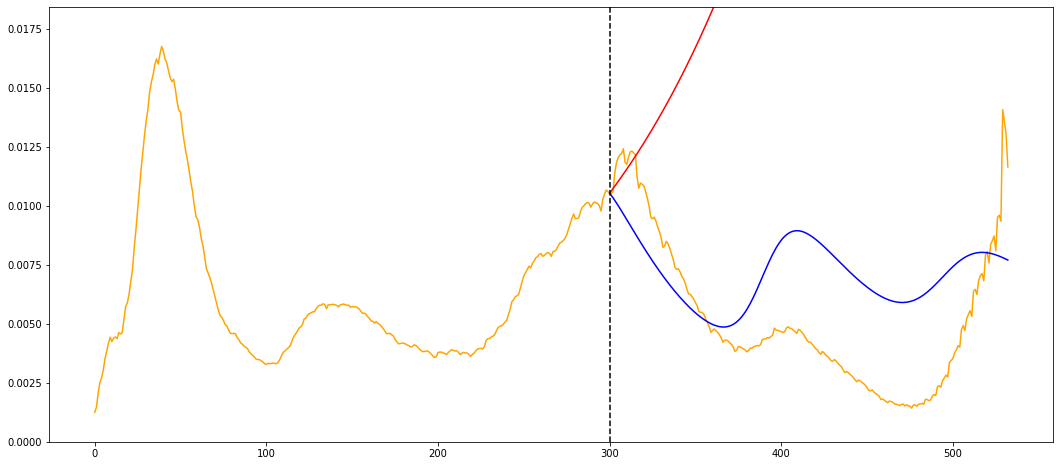

In [57]:
fig, ax = plt.subplots(figsize=(18,8))

usParams2 = usParams.copy()
usParamsConst2 = usParamsConst.copy()

usParamsConst2[0] = I[startSim] #set I[0] to I on the start sim date

simA, simI = gdm.simFunc(usParams, consts, giveA=True) #the normal simulation
usParams2[0] = simA[startSim] #set A[0] as what the simulated A was on the start sim date
usParams2[1] = I[startSim] #set I[0] to actual I on the start sim date

#simulations on sim date and on
simI = gdm.simFunc(usParams2, consts)
simConstI = gdm.simFuncConst(usParamsConst2, consts)

xSeries = np.arange(0,len(I),1)

ax.plot(xSeries, I, color="orange")
ax.plot(xSeries[startSim:], simI[:len(I)-startSim], color="blue")
ax.plot(xSeries[startSim:], simConstI[:len(I)-startSim], color="red")

ax.set_ylim([0, max(I)*1.1])

ax.axvline(x=startSim, color="black", linestyle='--')

..\Models\GradDescModels.py:50: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


0 New best error:  7.167972846301494e-05


..\Models\GradDescModels.py:50: RuntimeWarning: overflow encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


2 New best error:  5.048753693481267e-05


..\Models\GradDescModels.py:51: RuntimeWarning: overflow encountered in double_scalars
  diffI = gamma1*A[t] - nu*I[t]
..\Models\GradDescModels.py:51: RuntimeWarning: invalid value encountered in double_scalars
  diffI = gamma1*A[t] - nu*I[t]
..\Models\GradDescModels.py:69: RuntimeWarning: overflow encountered in double_scalars
  error = error + ((y[t] - x[t])**2)*wDecay**(len(y)-t+1) #squared error


3 New best error:  2.8845013943656233e-05
4 New best error:  2.395617153193631e-05
6 New best error:  1.3847855366826905e-05
12 New best error:  1.3178819480410244e-05
13 New best error:  1.1267088881142603e-05
18 New best error:  7.957243484216557e-06
0 New best error:  9.897239243623344e-06


..\Models\GradDescModels.py:474: RuntimeWarning: overflow encountered in double_scalars
  diffI = beta*I[t] - gamma*I[t]
..\Models\GradDescModels.py:475: RuntimeWarning: invalid value encountered in double_scalars
  I[t+1] = diffI + I[t]
..\Models\GradDescModels.py:486: RuntimeWarning: overflow encountered in double_scalars
  error = error + ((y[t] - x[t])**2)*wDecay**(len(y)-t+1) #squared error


10 New best error:  9.871364623217345e-06
17 New best error:  9.79791684532999e-06
30 New best error:  1.1125215976442073e-06


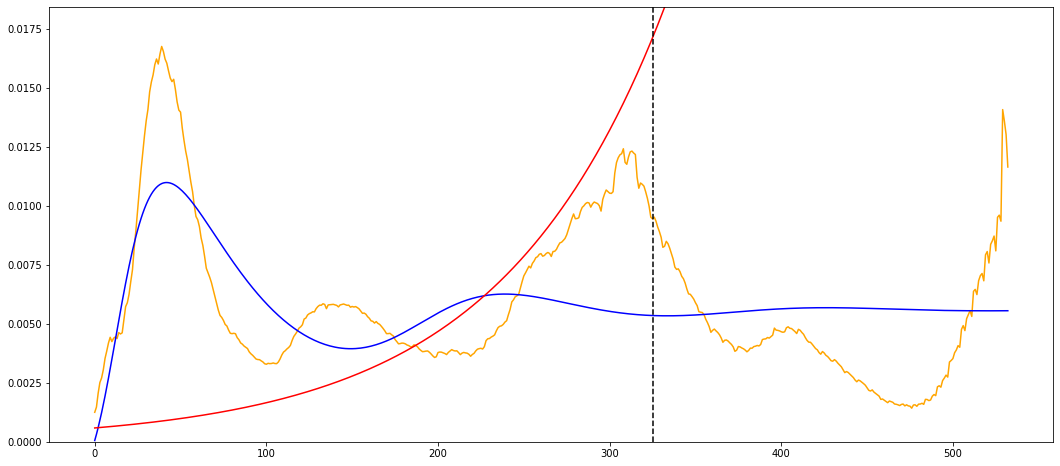

In [59]:
dates, I, R, D, V = owid.LoadCountryNormal("United States")

consts = [len(I), I[0], max(I), [len(I)]]

startSim = 325
sectionI=I[:startSim]
constsSection = [startSim, I[0], max(I), [startSim]] # fit only on range of [0:startSim] 

usParams =  gdm.getParams(sectionI, constsSection, randomIterCount=100)
usParamsConst = gdm.getParamsConst(sectionI, constsSection, wDecay=.97, randomIterCount=50)

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(I, color="orange")
ax.plot(gdm.simFunc(usParams, consts), color="blue")
ax.plot(gdm.simFuncConst(usParamsConst, consts), color="red")

ax.set_ylim([0, max(I)*1.1])

ax.axvline(x=startSim, color="black", linestyle='--')

In [37]:
import csv

fitFileName = "..\\..\\Data\\AIRD fits\\ItalySimFitsAlt.csv"
fitConstFileName = "..\\..\\Data\\AIRD fits\\ItalySimFitsConstAlt.csv"

simDates = [250, 270]

dates, IOrig, R, D, V, totI = owid.LoadCountryNormal("Italy")
I = smooth(IOrig, 14)
consts = [len(I), I[0], max(I)]


for simDate in simDates:
    sectionI = I[:simDate]
    constsSection = [simDate, I[0], max(I)]
    
    params =  gdm.getParams(sectionI, constsSection, randomIterCount=200, lastDay=.3, slopeWeight=2)
    #paramsConst = gdm.getParamsConst(sectionI, constsSection, randomIterCount=150, wDecay=.98)

    with open(fitFileName,'a', newline="") as fd: #append the row to fitFileName
        writer = csv.writer(fd)
        row = params.tolist()
        row.insert(0, str(simDate))
        writer.writerow(row)
        
    #with open(fitConstFileName,'a', newline="") as fd: #append the row to fitFileName
    #    writer = csv.writer(fd)
    #    row = paramsConst.tolist()
    #    row.insert(0, str(simDate))
    #    writer.writerow(row)
        
    print(simDate, "is done!")

0 New best error:  2.1481385324647793e-05
Iter:  4       

..\Models\GradDescModels.py:50: RuntimeWarning: overflow encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


82 New best error:  1.4581991974112518e-05
250 is done!   
0 New best error:  0.00012766864457553167
1 New best error:  8.827505646901686e-05
3 New best error:  6.228058221594345e-05
9 New best error:  5.928583672758043e-05
29 New best error:  4.60094936321793e-05
82 New best error:  4.381105358946029e-05
98 New best error:  3.201372420008763e-05
117 New best error:  2.4342089424431003e-05
Iter:  179     

C:\Users\Lemon\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\lib\function_base.py:1280: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


270 is done!   


In [33]:
import csv

fitFileName = "..\\..\\Data\\AIRD fits\\USSimFitsAlt.csv"
fitConstFileName = "..\\..\\Data\\AIRD fits\\USSimFitsConstAlt.csv"

simDates = [270, 315]

dates, IOrig, R, D, V, totI = owid.LoadCountryNormal("United States")
I = smooth(IOrig, 14) #smooth out so fitting is better
consts = [len(I), I[0], max(I)]


for simDate in simDates:
    sectionI = I[:simDate]
    constsSection = [simDate, I[0], max(I)]
    
    params =  gdm.getParams(sectionI, constsSection, randomIterCount=150, lastDay=.3, slopeWeight=2)
    paramsConst = gdm.getParamsConst(sectionI, constsSection, randomIterCount=150, wDecay=.98)

    with open(fitFileName,'a', newline="") as fd: #append the row to fitFileName
        writer = csv.writer(fd)
        row = params.tolist()
        row.insert(0, str(simDate))
        writer.writerow(row)
        
    with open(fitConstFileName,'a', newline="") as fd: #append the row to fitFileNameConst
        writer = csv.writer(fd)
        row = paramsConst.tolist()
        row.insert(0, str(simDate))
        writer.writerow(row)
        
    print(simDate, "is done!")

C:\Users\Lemon\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
..\Models\GradDescModels.py:50: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]
..\Models\GradDescModels.py:50: RuntimeWarning: overflow encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


1 New best error:  2.5554444330249196e-05
2 New best error:  1.2562707783885587e-05
16 New best error:  1.0145674720940911e-05
44 New best error:  8.78887978691661e-06
65 New best error:  6.600860425638573e-06
82 New best error:  4.799334817261698e-06
2 New best error:  6.416841451492269e-06
12 New best error:  6.416650717895097e-06
21 New best error:  6.41579120483543e-06
28 New best error:  6.389947538564557e-06
30 New best error:  6.3735098576694115e-06
32 New best error:  6.255060471613861e-06
54 New best error:  4.5088853393184605e-07
270 is done!   
0 New best error:  8.224168732914907e-05
1 New best error:  3.9698091347640835e-05
2 New best error:  1.340235138637867e-05
6 New best error:  1.1694726989230398e-05
27 New best error:  9.628829775828396e-06
Iter:  50      

C:\Users\Lemon\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\lib\function_base.py:1280: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


3 New best error:  1.2430485631771487e-05
5 New best error:  5.861288327307208e-07
Iter:  13      

C:\Users\Lemon\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


315 is done!   


In [12]:
import csv

def smooth(y, width):
    window = np.ones(width)/width
    y_smooth = np.convolve(y, window, mode='same')
    return y_smooth

#fitFileName = "..\\..\\Data\\AIRD fits\\CAFitPredict.csv"
#fit2FileName = "..\\..\\Data\\AIRD fits\\CAMeasureFitPredict.csv"
fit3FileName = "..\\..\\Data\\AIRD fits\\CAConstPredict.csv"
measureDates = getCountryDates("California Closure Data", filePathOver="../../Data/California Test Data/")

simDates = [280, 380]

#simDates = [225, 250, 275, 300, 325, 350]

dates, IOrig, R, D, totI = loadCAData()
I = smooth(IOrig, 14) #smooth out so fitting is better
consts = [len(I), I[0], max(I)]

for simDate in simDates:
    sectionI = I[:simDate]
    
    measureIndexes = []
    for measure in measureDates:
        measInd = getIndex(dates, measure)
        if(measInd >= len(sectionI)):
            break #out of range, stop here
        measureIndexes.append(measInd)
    measureIndexesAlt = measureIndexes.copy()
    measureIndexesAlt.append(len(sectionI))
    
    print(measureIndexesAlt)
    
    constsSection = [simDate, I[0], max(I), measureIndexesAlt]
    
    #paramsMeas =  gdm.getParamsB2(sectionI, constsSection, randomIterCount=300, lastDay=.5, slopeWeight=1) #the fit with the measures
    #paramsNorm = gdm.getParams(sectionI, constsSection, randomIterCount=200, lastDay=.5, slopeWeight=1) #the normal fit
    paramsConst = gdm.getParamsConst(sectionI, constsSection, randomIterCount=150, wDecay=.98)

    #with open(fitFileName,'a', newline="") as fd: #append the row to fitFileName
    #    writer = csv.writer(fd)
    #    row = paramsNorm.tolist()
    #    row.insert(0, str(simDate))
    #    writer.writerow(row)
        
    #with open(fit2FileName,'a', newline="") as fd: #append the row to fitFileName
    #    writer = csv.writer(fd)
    #    row = paramsMeas.tolist()
    #    row.insert(0, str(simDate))
    #    writer.writerow(row)
        
    with open(fit3FileName,'a', newline="") as fd: #append the row to fitFileName
        writer = csv.writer(fd)
        row = paramsConst.tolist()
        row.insert(0, str(simDate))
        writer.writerow(row)
        
    print(simDate, "is done!")

<ipython-input-12-7e4d769ece02>:11: ResourceWarning: unclosed file <_io.TextIOWrapper name='../../Data/California Test Data/California Closure Data.csv' mode='r' encoding='UTF-8'>
  measureDates = getCountryDates("California Closure Data", filePathOver="../../Data/California Test Data/")
<ipython-input-12-7e4d769ece02>:17: ResourceWarning: unclosed file <_io.TextIOWrapper name='../../Data/California Test Data/CA.csv' mode='r' encoding='UTF-8'>
  dates, IOrig, R, D, totI = loadCAData()
..\Models\GradDescModels.py:486: RuntimeWarning: overflow encountered in double_scalars
  diffI = beta*I[t] - gamma*I[t]


[1, 92, 163, 254, 280]
0 New best error:  1.0088657189042281e-05
16 New best error:  1.3966592737989897e-06
21 New best error:  8.264240443912391e-07
Iter:  35      

C:\Users\Lemon\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


280 is done!   
[1, 92, 163, 254, 313, 380]
2 New best error:  5.747484070587483e-06
8 New best error:  5.738388001943531e-06
22 New best error:  3.992400325112415e-06
35 New best error:  3.364505223111945e-06
380 is done!   


Dates available: 
275
290
260
280
250
270


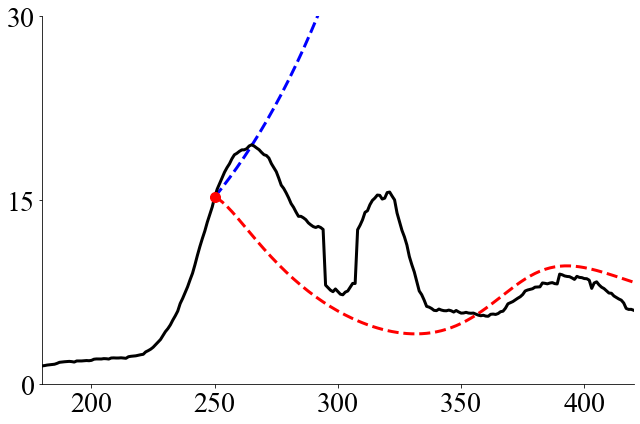

In [9]:
fitFileName = "..\\..\\Data\\AIRD fits\\ItalySimFitsAlt.csv"
fitConstFileName = "..\\..\\Data\\AIRD fits\\ItalySimFitsConstAlt.csv"
italyFits = loadDictionaryFromFitFile(fitFileName)
italyConstFits = loadDictionaryFromFitFile(fitConstFileName)

dates, I, R, D, V, totI = owid.LoadCountryNormal("Italy")
consts = [len(I), I[0], max(I)]

scale = 1000 * (totI*3.8/.25)

print("Dates available: ")
for simDateStr in italyFits:
    print(simDateStr)

simDateList = ["250"]
linestyles = ["dashed", "dotted"]

fig, ax = plt.subplots(figsize=(9,6))

import matplotlib.lines
plt.rcParams['font.family'] = "Times New Roman"

for i in range(len(simDateList)):
    simDateStr = simDateList[i]
    params = italyFits[simDateStr]
    paramsConst = italyConstFits[simDateStr]
    simDate = int(simDateStr)
    
    #ax.plot(scale*gdm.simFunc(params,consts), color="blue")
    
    xSeries = np.arange(0,len(I), 1)
    
    simA, simI = gdm.simFunc(params, consts, giveA=True)
    params[0] = simA[simDate]
    params[1] = I[simDate]
    paramsConst[0] = I[simDate]
    
    ax.plot(xSeries[simDate:], scale*gdm.simFunc(params,consts)[:-simDate], color="red", linewidth=3, linestyle=linestyles[i])
    ax.plot(xSeries[simDate:], scale*gdm.simFuncConst(paramsConst,consts)[:-simDate], color="blue", linewidth=3, linestyle=linestyles[i])
    
ax.plot(xSeries, scale*I, color="black", label="Data", linewidth=3)
ax.set_ylim([0, 30])

ax.set_yticks([0, 15, 30]) #manually set y ticks

#ax.set_ylabel("Infections", fontsize=32)
#ax.set_xlabel("Days", fontsize=32)
#ax.set_title("Italy", fontsize=36)
ax.tick_params(axis='x', labelsize=28)
ax.tick_params(axis='y', labelsize=28)

ax.plot([0],[1], color="red", linewidth=3, label="Feedback Model") #to show up in the legend
ax.plot([0],[1], color="green", linewidth=3, label="Standard Model") #to show up in the legend
#ax.legend(fontsize=30)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlim([180, 420])

for simDateStr in simDateList:
    simDate = int(simDateStr)
    ax.scatter(x=simDate, y=I[simDate]*scale, color="red", s=100, zorder=20) #zorder is layer number, s is size
    
plt.tight_layout()
plt.savefig("FiguresFinal/ItalySimulationsZoom.png", bbox_inches = 'tight')

Dates available: 
225
250
300
325
350
275
270
315


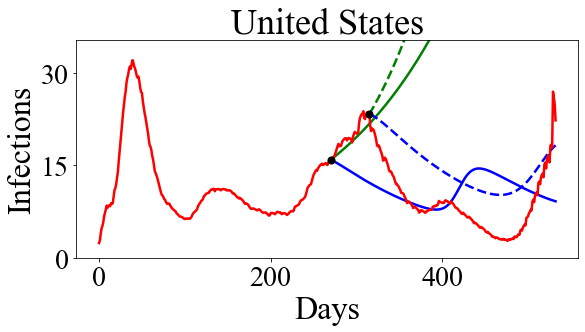

In [7]:
fitFileName = "..\\..\\Data\\AIRD fits\\USSimFitsAlt.csv"
fitConstFileName = "..\\..\\Data\\AIRD fits\\USSimFitsConstAlt.csv"
usFits = loadDictionaryFromFitFile(fitFileName)
usConstFits = loadDictionaryFromFitFile(fitConstFileName)

dates, I, R, D, V, totI = owid.LoadCountryNormal("United States")
consts = [len(I), I[0], max(I)]

scale = 1000 * (totI*4.2/.25)

print("Dates available: ")
for simDateStr in usFits:
    print(simDateStr)

simDateList = ["270", "315"]
linestyles = ["solid", "dashed", "dotted", "dotted","dotted", "dotted","dotted"]

fig, ax = plt.subplots(figsize=(9,4))

import matplotlib.lines
plt.rcParams['font.family'] = "Times New Roman"

for i in range(len(simDateList)):
    simDateStr = simDateList[i]
    params = usFits[simDateStr]
    paramsConst = usConstFits[simDateStr]
    simDate = int(simDateStr)
    
    #ax.plot(scale*gdm.simFunc(params,consts), color="blue")
    
    xSeries = np.arange(0,len(I),1)
    
    simA, simI = gdm.simFunc(params, consts, giveA=True)
    params[0] = simA[simDate]
    params[1] = I[simDate]
    paramsConst[0] = I[simDate]
    
    ax.plot(xSeries[simDate:], scale*gdm.simFunc(params,consts)[:-simDate], color="blue", linewidth=2.5, linestyle=linestyles[i])
    ax.plot(xSeries[simDate:], scale*gdm.simFuncConst(paramsConst,consts)[:-simDate], color="green", linewidth=2.5, linestyle=linestyles[i])
    
    
ax.plot(xSeries, I*scale, color="red", label="Data", linewidth=2.5)
ax.set_ylim([0, 1.1*max(I)*scale])

ax.set_yticks([0, 15, 30]) #manually set y ticks

ax.set_ylabel("Infections", fontsize=32)
ax.set_xlabel("Days", fontsize=32)
ax.set_title("United States", fontsize=36)
ax.tick_params(axis='x', labelsize=28)
ax.tick_params(axis='y', labelsize=28)

ax.plot([0],[1], color="blue", linewidth=2.5, label="Feedback Model") #to show up in the legend
ax.plot([0],[1], color="green", linewidth=2.5, label="Standard Model") #to show up in the legend
#ax.legend(fontsize=30)

#ax.scatter(x=simDate, y=I[simDate], color="black", label='Simulation Date')

for simDateStr in simDateList:
    simDate = int(simDateStr)
    ax.scatter(x=simDate, y=scale*I[simDate], color="black", s=50, zorder=20) #zorder is layer number, s is size
plt.savefig("Figures/USSimulationsLabeled.png", bbox_inches = 'tight')

C:\Users\Lemon\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


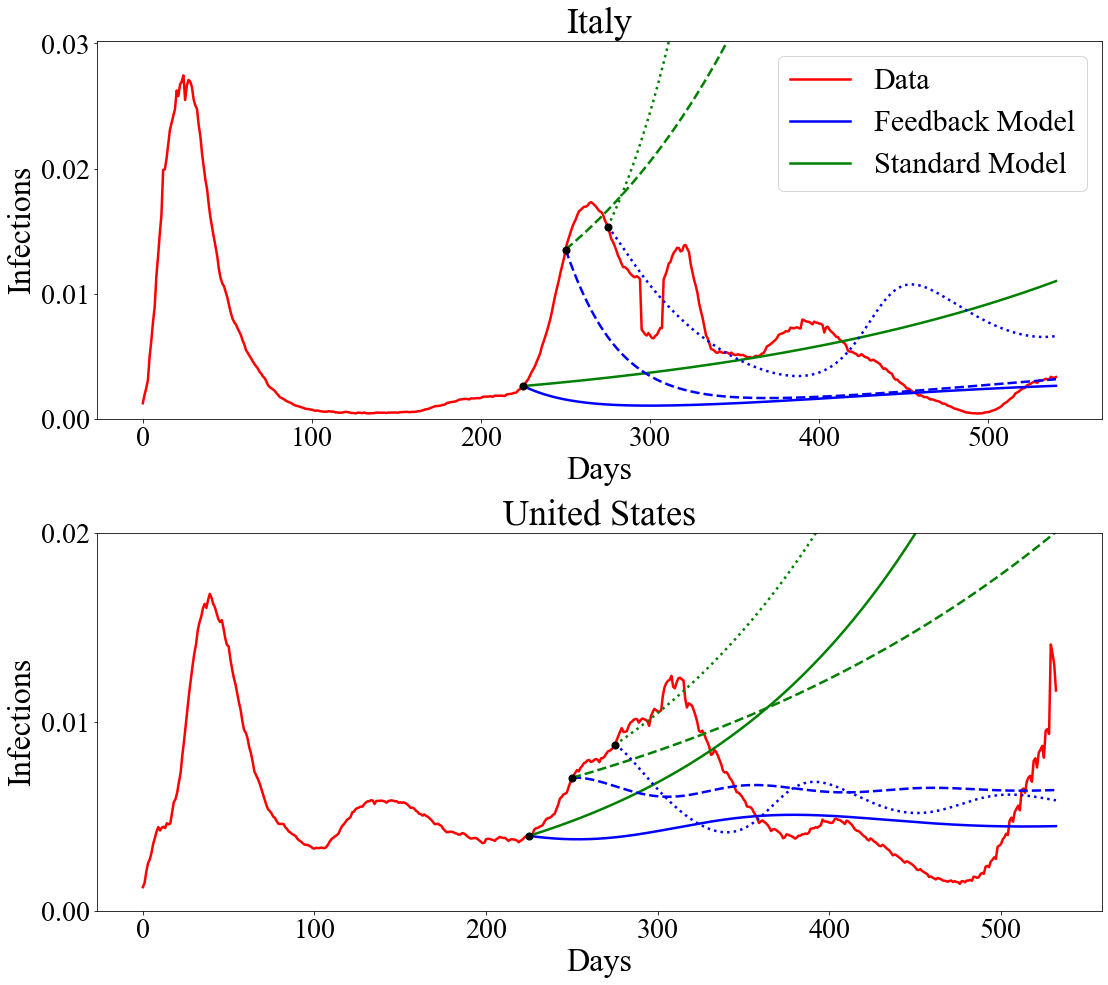

In [86]:
#merge both plots together
import matplotlib.lines

fig, ax = plt.subplots(2,1, figsize=(18,8*2))
plt.rcParams['font.family'] = "Times New Roman"

simDateList = ["225", "250", "275"]
linestyles = ["solid", "dashed", "dotted"]

######################################################## first plot

fitFileName = "..\\..\\Data\\AIRD fits\\ItalySimFits2.csv"
fitConstFileName = "..\\..\\Data\\AIRD fits\\ItalySimFitsConst2.csv"
italyFits = loadDictionaryFromFitFile(fitFileName)
italyConstFits = loadDictionaryFromFitFile(fitConstFileName)

dates, I, R, D, V = owid.LoadCountryNormal("Italy")
A = approxAsympt(I+R+D, shift=5)
consts = [len(I), I[0], max(I)]

for i in range(len(simDateList)):
    simDateStr = simDateList[i]
    params = italyFits[simDateStr]
    paramsConst = italyConstFits[simDateStr]
    simDate = int(simDateStr)
    
    xSeries = np.arange(0,len(I), 1)
    
    simA, simI = gdm.simFunc(params, consts, giveA=True)
    params[0] = simA[simDate]
    
    #alternate way to get A[0], approximate and substitute
    #params[0] = A[simDate]
    
    params[1] = I[simDate]
    paramsConst[0] = I[simDate]
    
    ax[0].plot(xSeries[simDate:], gdm.simFunc(params,consts)[:-simDate], color="blue", linewidth=2.5, linestyle=linestyles[i])
    ax[0].plot(xSeries[simDate:], gdm.simFuncConst(paramsConst,consts)[:-simDate], color="green", linewidth=2.5, linestyle=linestyles[i])
    
ax[0].plot(xSeries, I, color="red", label="Data", linewidth=2.5, zorder=1)
ax[0].set_ylim([0, 1.1*max(I)])

ax[0].set_yticks([0, .01, .02, .03]) #manually set y ticks

ax[0].set_ylabel("Infections", fontsize=32)
ax[0].set_xlabel("Days", fontsize=32)
ax[0].set_title("Italy", fontsize=36)
ax[0].tick_params(axis='x', labelsize=28)
ax[0].tick_params(axis='y', labelsize=28)

ax[0].plot([0],[1], color="blue", linewidth=2.5, label="Feedback Model") #to show up in the legend
ax[0].plot([0],[1], color="green", linewidth=2.5, label="Standard Model") #to show up in the legend
ax[0].legend(fontsize=30)


for simDateStr in simDateList:
    simDate = int(simDateStr)
    ax[0].scatter(x=simDate, y=I[simDate], color="black", s=50, zorder=20) #zorder is layer number, s is size

#ax[0].plot(A)
    
######################################################## second plot

fitFileName = "..\\..\\Data\\AIRD fits\\USSimFitsWD.csv"
fitConstFileName = "..\\..\\Data\\AIRD fits\\USSimFitsConst2.csv"
usFits = loadDictionaryFromFitFile(fitFileName)
usConstFits = loadDictionaryFromFitFile(fitConstFileName)

dates, I, R, D, V = owid.LoadCountryNormal("United States")
A = approxAsympt(I+R+D, shift=5)
consts = [len(I), I[0], max(I)]

for i in range(len(simDateList)):
    simDateStr = simDateList[i]
    params = usFits[simDateStr]
    paramsConst = usConstFits[simDateStr]
    simDate = int(simDateStr)
    
    xSeries = np.arange(0,len(I),1)
    
    simA, simI = gdm.simFunc(params, consts, giveA=True)
    params[0] = simA[simDate] #the A(0)
    
    #alternate way to get A[0], approximate and substitute, doesn't seem to work well
    #params[0] = A[simDate]
    
    params[1] = I[simDate]
    paramsConst[0] = I[simDate]
    
    ax[1].plot(xSeries[simDate:], gdm.simFunc(params,consts)[:-simDate], color="blue", linewidth=2.5, linestyle=linestyles[i])
    ax[1].plot(xSeries[simDate:], gdm.simFuncConst(paramsConst,consts)[:-simDate], color="green", linewidth=2.5, linestyle=linestyles[i])
    
    
ax[1].plot(xSeries, I, color="red", label="Data", linewidth=2.5, zorder=1)
ax[1].set_ylim([0, 1.1*max(I)])

ax[1].set_yticks([0, .01, .02]) #manually set y ticks

ax[1].set_ylabel("Infections", fontsize=32)
ax[1].set_xlabel("Days", fontsize=32)
ax[1].set_title("United States", fontsize=36)
ax[1].tick_params(axis='x', labelsize=28)
ax[1].tick_params(axis='y', labelsize=28)

ax[1].plot([0],[1], color="blue", linewidth=2.5, label="Feedback Model") #to show up in the legend
ax[1].plot([0],[1], color="green", linewidth=2.5, label="Standard Model") #to show up in the legend
#ax[1].legend(fontsize=30)
#ax[1].plot(A)
#ax.scatter(x=simDate, y=I[simDate], color="black", label='Simulation Date')

for simDateStr in simDateList:
    simDate = int(simDateStr)
    ax[1].scatter(x=simDate, y=I[simDate], color="black", s=50, zorder=20) #zorder is layer number, s is size
    
fig.subplots_adjust(hspace=.3)
#save the figure
#plt.savefig("Figures/SimFigure.eps", bbox_inches = 'tight')
#plt.savefig("Figures/SimFigure.jpeg", bbox_inches = 'tight')

In [70]:
def approxAsympt(Itotal, shift=5): #assume asymptomatics are just infected 5 days earlier
    asymptTotal = np.zeros(np.shape(Itotal))
    asymptTotal[0:-shift] = Itotal[shift:]
    #last shift days aren't defined approximate as I data
    asymptTotal[-shift:] = Itotal[-shift:]
    
    A = asymptTotal - Itotal #current asympt
    return A #A could also have some scaler if some A go right to R

C:\Users\Lemon\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\Lemon\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


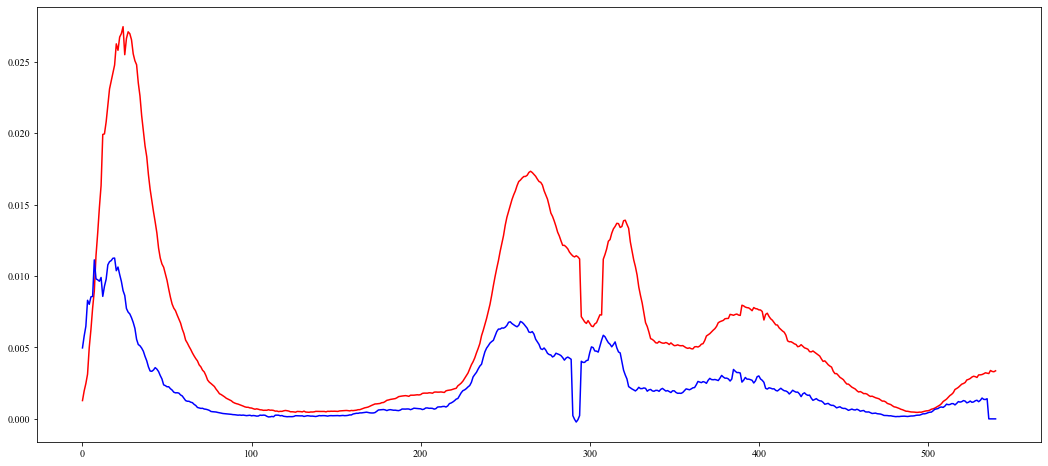

In [69]:
dates, I, R, D, V = owid.LoadCountryNormal("Italy")
A = approxAsympt(I+R+D, shift=5)
consts = [len(I), I[0], max(I)]

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(I, color="red")
ax.plot(A, color="blue")